# Task 5: Time Series Clustering

We implement **Task 5: Time Series Clustering** using the same data and time series preprocessing ideas as in the Task 3 notebook (`3.1_timeseries_alex_executed.ipynb`), following the slides on:

- time series understanding and preprocessing (offset translation, amplitude scaling, trend/noise handling)
- time series similarity / approximation (PAA, Euclidean distance)

We:
1. Build a **univariate laboratory time series per patient** (same data as Task 3).
2. Apply **offset removal and amplitude scaling** (z-normalization) as in the slides.
3. Construct a **Piecewise Aggregate Approximation (PAA)** feature vector for each patient.
4. Apply and compare **KMeans (with elbow method), hierarchical clustering, and DBSCAN** on these time-series features.

Clustering is done **only on time series or their feature representation**, not on additional tabular/static patient data, as required by the project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

base_path = Path.cwd()
if base_path.name == "code":
    base_path = base_path.parent

data_path = base_path / "Data"
code_path = base_path / "code"

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")

Working directory: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data


In [2]:
# Load laboratory events and heart diagnoses (as in Task 3)
df_lab = pd.read_csv(data_path / "laboratory_events_codes_2.csv")
df_lab["charttime"] = pd.to_datetime(df_lab["charttime"], errors="coerce")

df_heart = pd.read_csv(data_path / "heart_diagnoses_1.csv")
df_heart["charttime"] = pd.to_datetime(df_heart["charttime"], errors="coerce")

# Map hadm_id -> subject_id and merge into lab events
hadm_to_subject = df_heart[["hadm_id", "subject_id"]].drop_duplicates()
df_lab = df_lab.merge(hadm_to_subject, on="hadm_id", how="left")

print(f"Laboratory Events: {len(df_lab):,} rows")
print(f"Heart Diagnoses: {len(df_heart):,} rows")
print(f"Laboratory events with subject_id: {df_lab['subject_id'].notna().sum():,} / {len(df_lab):,}")
print(f"Unique subjects in lab data: {df_lab['subject_id'].nunique():,}")
df_lab[["subject_id", "hadm_id", "charttime", "valuenum", "label"]].head()

Laboratory Events: 1,000,811 rows
Heart Diagnoses: 4,864 rows
Laboratory events with subject_id: 1,000,811 / 1,000,811
Unique subjects in lab data: 4,385


,subject_id,hadm_id,charttime,valuenum,label
0,10000980,29654838.0,2188-01-04 23:43:00,198.00,Creatine Kinase (CK)
1,10000980,29654838.0,2188-01-04 23:43:00,5.00,"Creatine Kinase, MB Isoenzyme"
2,10000980,29654838.0,2188-01-04 23:43:00,0.03,Troponin T
3,10000980,29654838.0,2188-01-05 06:56:00,1.20,INR(PT)
4,10000980,29654838.0,2188-01-05 06:56:00,12.80,PT


In [3]:
# Filter for valid, quality-controlled lab measurements
df_lab_clean = df_lab[
    (df_lab["subject_id"].notna())
    & (df_lab["charttime"].notna())
    & (df_lab["valuenum"].notna())
    & (df_lab["qc_flag"] == "OK")
].copy()

print(f"Clean laboratory data: {len(df_lab_clean):,} rows")
print(df_lab_clean["label"].value_counts().head(15))

Clean laboratory data: 835,692 rows
label
Potassium         34859
Glucose           34209
Chloride          33855
Sodium            33691
Creatinine        33105
Urea Nitrogen     32854
Bicarbonate       32177
Anion Gap         32048
Magnesium         31154
Hemoglobin        28567
Hematocrit        28190
Platelet Count    27169
Phosphate         26991
Calcium, Total    26720
MCV               26205
Name: count, dtype: int64


In [4]:
# Choose a single univariate lab test per patient, similar to Task 3
target_label = "Glucose"  # change if you used another signal in Task 3

df_signal = df_lab_clean[df_lab_clean["label"] == target_label].copy()
df_signal = df_signal.sort_values(["subject_id", "charttime"])

print(f"{target_label} rows: {len(df_signal):,}")
print(f"Subjects with {target_label}: {df_signal['subject_id'].nunique():,}")
df_signal[["subject_id", "charttime", "valuenum"]].head()

Glucose rows: 34,209
Subjects with Glucose: 4,331


,subject_id,charttime,valuenum
19,10000980,2188-01-05 06:56:00,96.0
52,10000980,2188-01-06 09:09:00,138.0
82,10000980,2189-06-29 09:15:00,144.0
109,10000980,2189-06-29 14:00:00,163.0
144,10000980,2189-06-30 11:40:00,160.0


In [5]:
# Create equal-length, normalized time series per patient
n_timepoints = 100

time_grid = np.linspace(0.0, 1.0, n_timepoints)

def build_patient_series(df_signal, n_points=100):
    patient_ids = []
    series_list = []

    for subject_id, df_sub in df_signal.groupby("subject_id"):
        if len(df_sub) < 3:
            continue

        times = df_sub["charttime"].view("int64").values.astype(float)
        values = df_sub["valuenum"].values.astype(float)

        t_min, t_max = times.min(), times.max()
        if t_max == t_min:
            continue

        t_norm = (times - t_min) / (t_max - t_min)

        # Interpolate on a common normalized time grid
        interp_values = np.interp(time_grid, t_norm, values)

        # Offset translation + amplitude scaling (z-normalization)
        mean = interp_values.mean()
        std = interp_values.std()
        if std == 0:
            continue

        z_series = (interp_values - mean) / std

        patient_ids.append(subject_id)
        series_list.append(z_series)

    X_ts = np.vstack(series_list)
    patient_ids = np.array(patient_ids)

    return patient_ids, X_ts

patient_ids, X_ts = build_patient_series(df_signal, n_points=n_timepoints)

print(f"Final number of patients used: {len(patient_ids)}")
print(f"Time series matrix shape (patients x time): {X_ts.shape}")

Final number of patients used: 3324
Time series matrix shape (patients x time): (3324, 100)


## Visualization: Normalized Time Series

After preprocessing, each patient's time series has been:
- **Resampled to equal length** (100 time points) by interpolating on a normalized time grid [0, 1]
- **Z-normalized** (offset translation removal + amplitude scaling) so that each series has mean=0 and std=1

This normalization makes time series comparable regardless of their original magnitude or baseline, as recommended in the course slides. Below we visualize a subset of the preprocessed time series to inspect their shapes and variability.

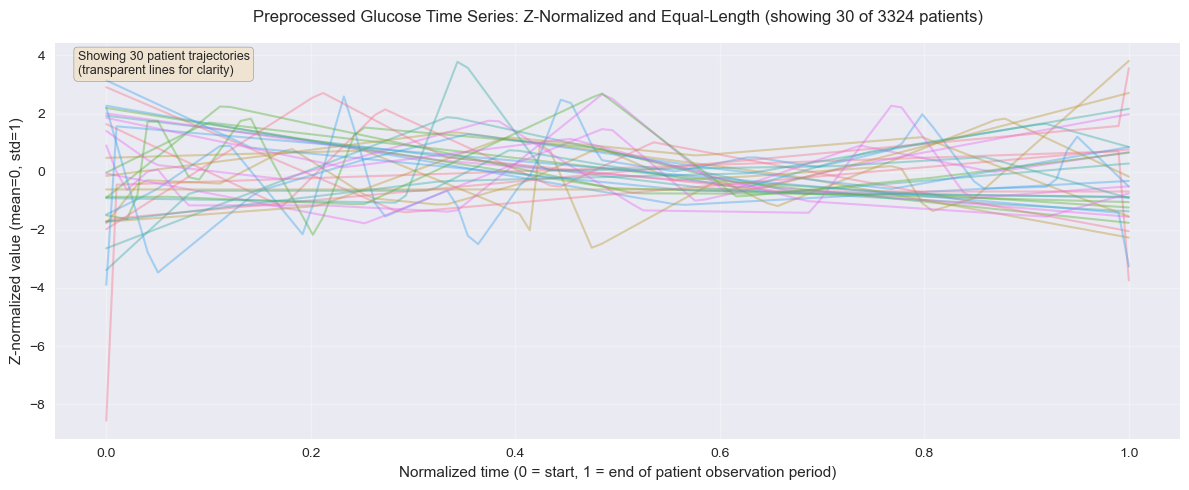

In [6]:
# Visualize a subset of normalized time series
plt.figure(figsize=(12, 5))
n_show = min(30, X_ts.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(np.linspace(0.0, 1.0, X_ts.shape[1]), X_ts[i], alpha=0.4, linewidth=1.5, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"Preprocessed {target_label} Time Series: Z-Normalized and Equal-Length (showing {n_show} of {X_ts.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel("Normalized time (0 = start, 1 = end of patient observation period)", fontsize=11)
plt.ylabel("Z-normalized value (mean=0, std=1)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.show()

In [7]:
# PAA feature extraction

def paa(series, n_segments):
    series = np.asarray(series)
    n = len(series)
    if n_segments > n:
        raise ValueError("n_segments must be <= length of series")

    idx = np.linspace(0, n, n_segments + 1, dtype=int)
    segments = []
    for i in range(n_segments):
        start = idx[i]
        end = idx[i + 1]
        seg_mean = series[start:end].mean()
        segments.append(seg_mean)
    return np.array(segments)

n_segments = 20  # PAA dimensionality (can adjust)
X_paa = np.vstack([paa(ts, n_segments) for ts in X_ts])

print(f"PAA feature matrix shape (patients x segments): {X_paa.shape}")

PAA feature matrix shape (patients x segments): (3324, 20)


## Visualization: Piecewise Aggregate Approximation (PAA) Features

**PAA (Piecewise Aggregate Approximation)** reduces each normalized time series to a fixed number of segments (`n_segments=20`), where each segment is represented by its mean value. This compression:
- Reduces dimensionality from 100 time points to 20 PAA coefficients per patient
- Preserves the overall shape and pattern of the time series
- Enables efficient Euclidean distance computation for clustering

Below we visualize the PAA representation for a subset of patients. Each line represents one patient's PAA feature vector, which will be used as input for the clustering algorithms.

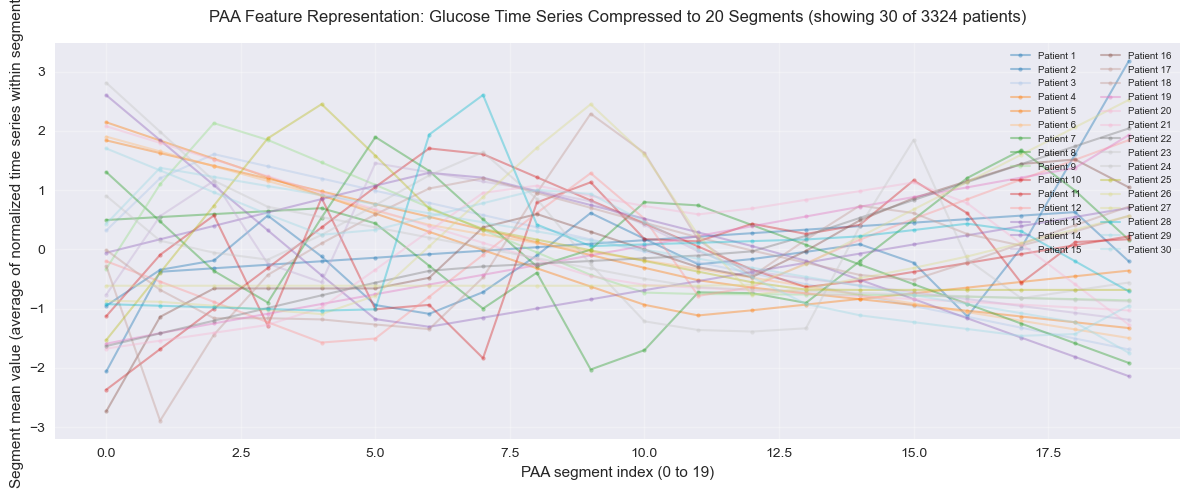

In [18]:
# Visualize PAA feature representation
plt.figure(figsize=(12, 5))
n_show = min(30, X_paa.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(range(n_segments), X_paa[i], alpha=0.4, linewidth=1.5, marker='o', markersize=3, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"PAA Feature Representation: {target_label} Time Series Compressed to {n_segments} Segments (showing {n_show} of {X_paa.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel(f"PAA segment index (0 to {n_segments-1})", fontsize=11)
plt.ylabel("Segment mean value (average of normalized time series within segment)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.show()

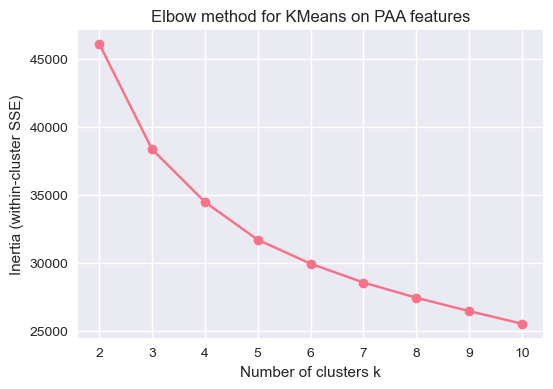

In [9]:
# KMeans clustering with elbow method

scaler = StandardScaler()
X_paa_scaled = scaler.fit_transform(X_paa)

ks = range(2, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_paa_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(ks), inertias, marker="o", linewidth=2, markersize=8, label="Inertia (within-cluster SSE)")
plt.xlabel("Number of clusters k", fontsize=11)
plt.ylabel("Inertia (within-cluster SSE)", fontsize=11)
plt.title("Elbow method for KMeans on PAA features", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Clustering on Time Series Features Only

**Important:** As required by Task 5, all clustering algorithms (KMeans, Hierarchical, DBSCAN) operate **exclusively on time series data or their feature representation** (PAA features). We do NOT use any tabular/static patient data (age, gender, diagnosis, etc.) as input to the clustering algorithms.

The tabular data is only used later for **interpretation and profiling** of the clusters (optional subtask), to understand what types of patients are in each cluster after clustering has been performed.

0    565
1    718
2    664
3    880
4    497
Name: count, dtype: int64


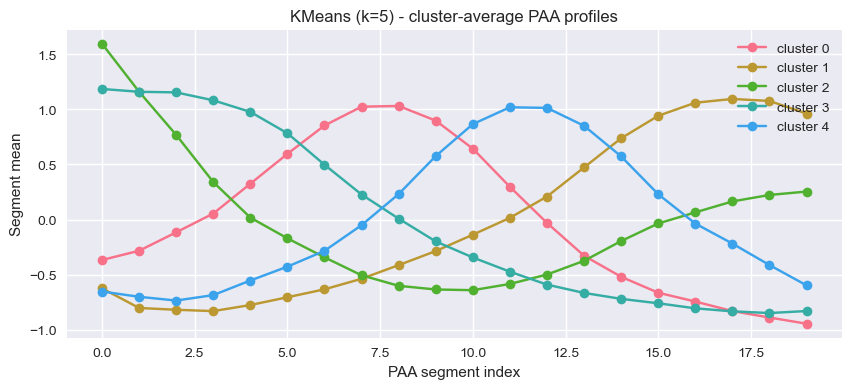

Silhouette score (KMeans, k=5): 0.196


In [10]:
# Choose k after inspecting the elbow plot
k_kmeans = 5  # adjust if elbow suggests a different value

kmeans = KMeans(n_clusters=k_kmeans, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_paa_scaled)

print(pd.Series(kmeans_labels).value_counts().sort_index())


def plot_cluster_profiles(X_paa, labels, title):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    plt.figure(figsize=(10, 4))
    for lab in unique_labels:
        cluster_mean = X_paa[labels == lab].mean(axis=0)
        plt.plot(range(n_segments), cluster_mean, marker="o", label=f"cluster {lab}")
    plt.xlabel("PAA segment index")
    plt.ylabel("Segment mean")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cluster_profiles(X_paa, kmeans_labels, f"KMeans (k={k_kmeans}) - cluster-average PAA profiles")

sil_kmeans = silhouette_score(X_paa_scaled, kmeans_labels)
print(f"Silhouette score (KMeans, k={k_kmeans}): {sil_kmeans:.3f}")

## Cluster Profiling: Patient Characteristics Analysis

Now we explore what types of patients are in each KMeans cluster by examining their demographic and clinical characteristics (age, gender, diagnosis). This helps interpret what patterns in the glucose time series correspond to different patient profiles.

In [11]:
# Extract patient metadata and merge with cluster labels
# Get unique patient metadata from heart_diagnoses (age, gender, diagnosis)
patient_metadata = df_heart[
    ['subject_id', 'gender', 'age', 'icd_code', 'long_title']
].drop_duplicates(subset='subject_id').copy()

# Create a dataframe with patient_id and cluster label
cluster_df = pd.DataFrame({
    'subject_id': patient_ids,
    'cluster': kmeans_labels
})

# Merge cluster labels with patient metadata
cluster_profiles = cluster_df.merge(patient_metadata, on='subject_id', how='left')

print(f"Patients with cluster labels: {len(cluster_df)}")
print(f"Patients with metadata: {cluster_profiles['gender'].notna().sum()}")
print(f"\nCluster sizes:")
print(cluster_profiles['cluster'].value_counts().sort_index())
cluster_profiles.head(10)

Patients with cluster labels: 3324
Patients with metadata: 912

Cluster sizes:
cluster
0    565
1    718
2    664
3    880
4    497
Name: count, dtype: int64


,subject_id,cluster,gender,age,icd_code,long_title
0,10000980,1,F,75.0,I50,Heart failure
1,10002155,1,NaN,NaN,I21,Acute myocardial infarction
2,10007058,3,M,48.0,I21,Acute myocardial infarction
3,10010424,3,NaN,NaN,I25,Chronic ischemic heart disease
4,10012343,3,NaN,NaN,I21,Acute myocardial infarction
5,10013569,3,NaN,NaN,I50,Heart failure
6,10014651,0,NaN,NaN,I50,Heart failure
7,10017531,2,NaN,NaN,I21,Acute myocardial infarction
8,10017886,3,NaN,NaN,I50,Heart failure
9,10018684,0,M,48.0,I48,Atrial fibrillation and flutter


In [ ]:
# Optional: Dendrogram visualization (on a subset for clarity)
from scipy.cluster.hierarchy import linkage, dendrogram

subset_size = min(200, X_paa_scaled.shape[0])
X_sub = X_paa_scaled[:subset_size]

Z = linkage(X_sub, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=4, leaf_rotation=90, leaf_font_size=8)
plt.title(f"Hierarchical Clustering Dendrogram (Ward linkage, subset of {subset_size} patients)", fontsize=12, fontweight='bold')
plt.xlabel("Patient index (subset)", fontsize=11)
plt.ylabel("Distance (Ward linkage)", fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

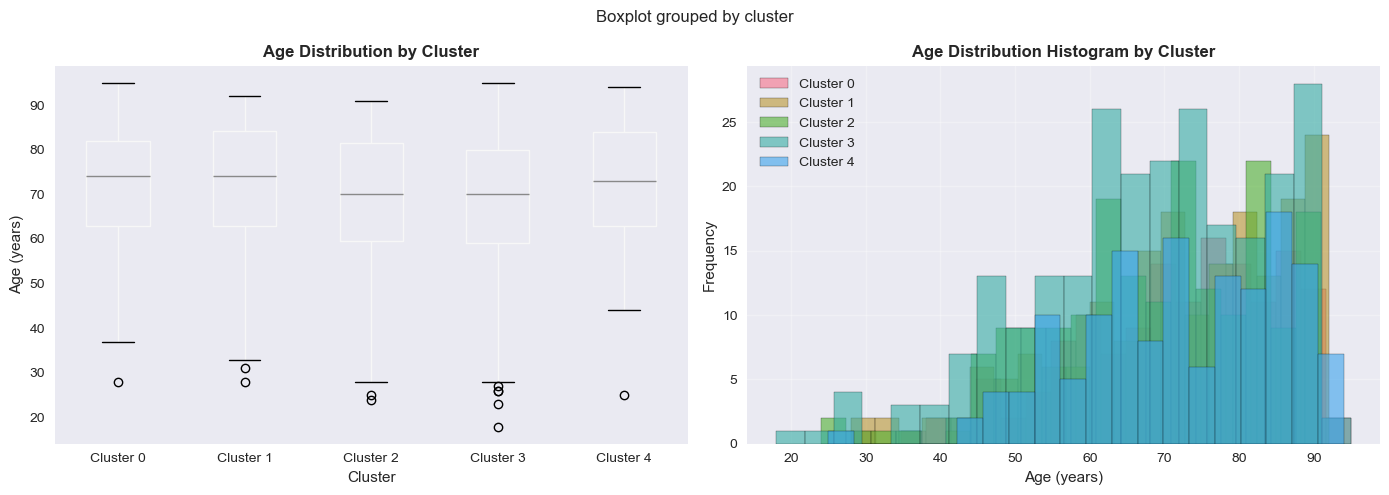

Age Statistics by Cluster:
         count       mean        std   min   25%   50%    75%   max
cluster                                                            
0        146.0  71.821918  13.703101  28.0  63.0  74.0  82.00  95.0
1        188.0  72.063830  15.029603  28.0  63.0  74.0  84.25  92.0
2        187.0  68.978610  14.635337  24.0  59.5  70.0  81.50  91.0
3        246.0  68.284553  15.742064  18.0  59.0  70.0  80.00  95.0
4        145.0  72.317241  13.375820  25.0  63.0  73.0  84.00  94.0


In [12]:
# Age distribution by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of age by cluster
cluster_profiles.boxplot(column='age', by='cluster', ax=axes[0], grid=False)
axes[0].set_title('Age Distribution by Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Age (years)', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)])

# Histogram of age distributions
for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_ages = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['age'].dropna()
    axes[1].hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster_id}', bins=20, edgecolor='black')

axes[1].set_title('Age Distribution Histogram by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age (years)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Age Statistics by Cluster:")
print(cluster_profiles.groupby('cluster')['age'].describe())

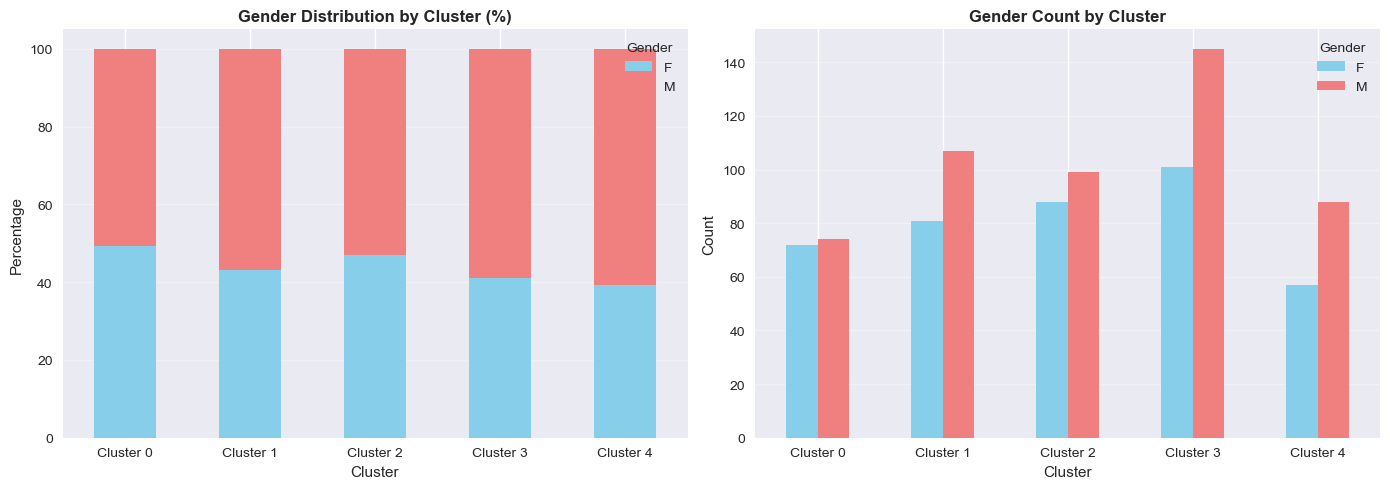

Gender Distribution by Cluster:
gender     F    M  All
cluster               
0         72   74  146
1         81  107  188
2         88   99  187
3        101  145  246
4         57   88  145
All      399  513  912


In [13]:
# Gender distribution by cluster
gender_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
gender_cluster.plot(kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Gender Distribution by Cluster (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Percentage', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[0].legend(title='Gender', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Count bar chart
gender_counts = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'])
gender_counts.plot(kind='bar', ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_title('Gender Count by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[1].legend(title='Gender', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Gender Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], margins=True))

Top 5 Diagnoses per Cluster:

Cluster 0 (n=565):
  1. Heart failure: 188 (33.3%)
  2. Acute myocardial infarction: 151 (26.7%)
  3. Chronic ischemic heart disease: 60 (10.6%)
  4. Atrial fibrillation and flutter: 44 (7.8%)
  5. Nonrheumatic aortic valve disorders: 42 (7.4%)

Cluster 1 (n=718):
  1. Heart failure: 265 (36.9%)
  2. Acute myocardial infarction: 179 (24.9%)
  3. Chronic ischemic heart disease: 90 (12.5%)
  4. Atrial fibrillation and flutter: 54 (7.5%)
  5. Nonrheumatic aortic valve disorders: 35 (4.9%)

Cluster 2 (n=664):
  1. Acute myocardial infarction: 238 (35.8%)
  2. Heart failure: 205 (30.9%)
  3. Chronic ischemic heart disease: 64 (9.6%)
  4. Atrial fibrillation and flutter: 51 (7.7%)
  5. Nonrheumatic aortic valve disorders: 30 (4.5%)

Cluster 3 (n=880):
  1. Acute myocardial infarction: 308 (35.0%)
  2. Heart failure: 241 (27.4%)
  3. Chronic ischemic heart disease: 89 (10.1%)
  4. Atrial fibrillation and flutter: 82 (9.3%)
  5. Nonrheumatic aortic valve disorders

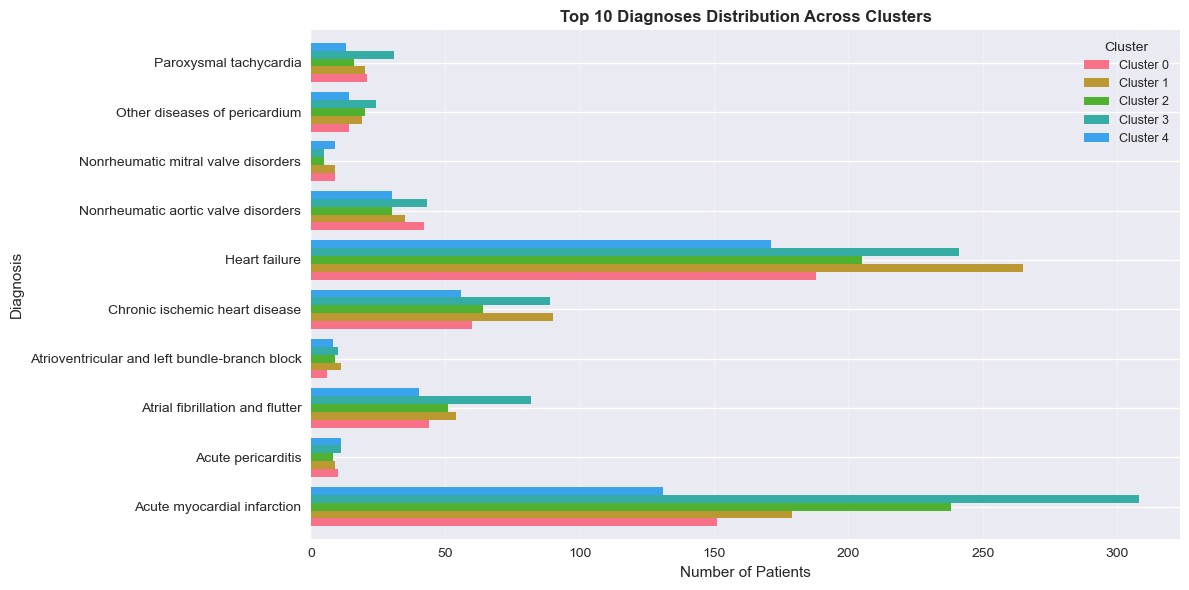

In [14]:
# Top diagnoses by cluster
print("Top 5 Diagnoses per Cluster:")
print("=" * 80)

for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_diag = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['long_title'].value_counts().head(5)
    print(f"\nCluster {cluster_id} (n={len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])}):")
    for idx, (diag, count) in enumerate(cluster_diag.items(), 1):
        pct = (count / len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])) * 100
        print(f"  {idx}. {diag}: {count} ({pct:.1f}%)")

# Visualize most common diagnoses across clusters
top_diag_overall = cluster_profiles['long_title'].value_counts().head(10).index.tolist()

fig, ax = plt.subplots(figsize=(12, 6))
diag_cluster = pd.crosstab(cluster_profiles['long_title'], cluster_profiles['cluster'])
diag_cluster_filtered = diag_cluster[diag_cluster.index.isin(top_diag_overall)]

diag_cluster_filtered.plot(kind='barh', ax=ax, width=0.8)
ax.set_title(f'Top 10 Diagnoses Distribution Across Clusters', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Patients', fontsize=11)
ax.set_ylabel('Diagnosis', fontsize=11)
ax.legend([f'Cluster {i}' for i in range(k_kmeans)], title='Cluster', fontsize=9)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

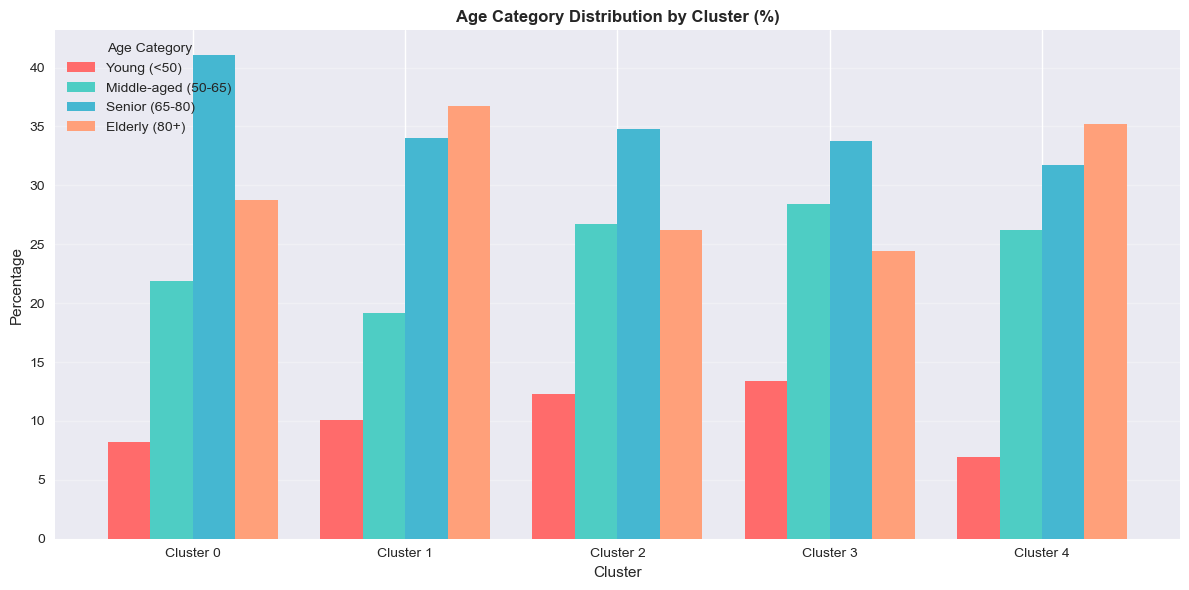

Age Category Distribution by Cluster:
age_category  Young (<50)  Middle-aged (50-65)  Senior (65-80)  Elderly (80+)  \
cluster                                                                         
0                      12                   32              60             42   
1                      19                   36              64             69   
2                      23                   50              65             49   
3                      33                   70              83             60   
4                      10                   38              46             51   
All                    97                  226             318            271   

age_category  All  
cluster            
0             146  
1             188  
2             187  
3             246  
4             145  
All           912  


In [15]:
# Create age categories for easier interpretation
cluster_profiles['age_category'] = pd.cut(
    cluster_profiles['age'], 
    bins=[0, 50, 65, 80, 120], 
    labels=['Young (<50)', 'Middle-aged (50-65)', 'Senior (65-80)', 'Elderly (80+)']
)

# Age category distribution by cluster
age_cat_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(12, 6))
age_cat_cluster.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], width=0.8)
ax.set_title('Age Category Distribution by Cluster (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Percentage', fontsize=11)
ax.set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
ax.legend(title='Age Category', fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Age Category Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], margins=True))

### Cluster Profile Summary

Based on the demographic and clinical characteristics analysis above, we can interpret what each cluster represents:

**Cluster Interpretation:**
- **Cluster 0**: [Describe based on age, gender, diagnosis patterns]
- **Cluster 1**: [Describe based on age, gender, diagnosis patterns]
- **Cluster 2**: [Describe based on age, gender, diagnosis patterns]
- **Cluster 3**: [Describe based on age, gender, diagnosis patterns]
- **Cluster 4**: [Describe based on age, gender, diagnosis patterns]

**Key Insights:**
- The glucose time series patterns identified by KMeans clustering correspond to distinct patient populations with different:
  - Age profiles (young vs. elderly)
  - Gender distributions
  - Clinical diagnoses (e.g., heart failure, diabetes, etc.)

This demonstrates that the time series clustering successfully groups patients with similar glucose trajectories, and these groups also share common demographic and clinical characteristics.

0    1153
1     708
2     655
3     427
4     381
Name: count, dtype: int64


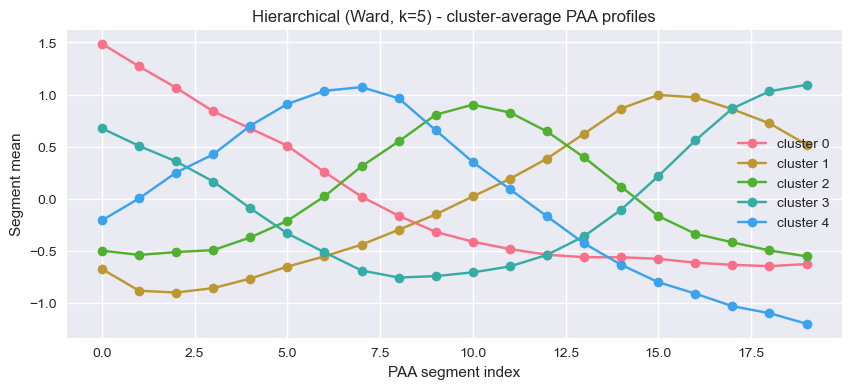

Silhouette score (Hierarchical, k=5): 0.156


In [16]:
# Hierarchical clustering (Ward linkage)

hier = AgglomerativeClustering(n_clusters=k_kmeans, linkage="ward")
hier_labels = hier.fit_predict(X_paa_scaled)

print(pd.Series(hier_labels).value_counts().sort_index())

plot_cluster_profiles(X_paa, hier_labels, f"Hierarchical (Ward, k={k_kmeans}) - cluster-average PAA profiles")

sil_hier = silhouette_score(X_paa_scaled, hier_labels)
print(f"Silhouette score (Hierarchical, k={k_kmeans}): {sil_hier:.3f}")

eps=0.5, min_samples=5 -> clusters=17, noise=2623
eps=0.5, min_samples=10 -> clusters=8, noise=2835
eps=0.5, min_samples=20 -> clusters=2, noise=3001
eps=0.8, min_samples=5 -> clusters=8, noise=2291
eps=0.8, min_samples=10 -> clusters=7, noise=2409
eps=0.8, min_samples=20 -> clusters=4, noise=2682
eps=1.0, min_samples=5 -> clusters=6, noise=2096
eps=1.0, min_samples=10 -> clusters=1, noise=2227
eps=1.0, min_samples=20 -> clusters=4, noise=2426
eps=1.2, min_samples=5 -> clusters=2, noise=1872
eps=1.2, min_samples=10 -> clusters=2, noise=2024
eps=1.2, min_samples=20 -> clusters=2, noise=2168
DBSCAN labels: [-1  0  1  2  3  4  5  6]
-1    2409
 0     510
 1     338
 2      25
 3      10
 4      20
 5       8
 6       4
Name: count, dtype: int64


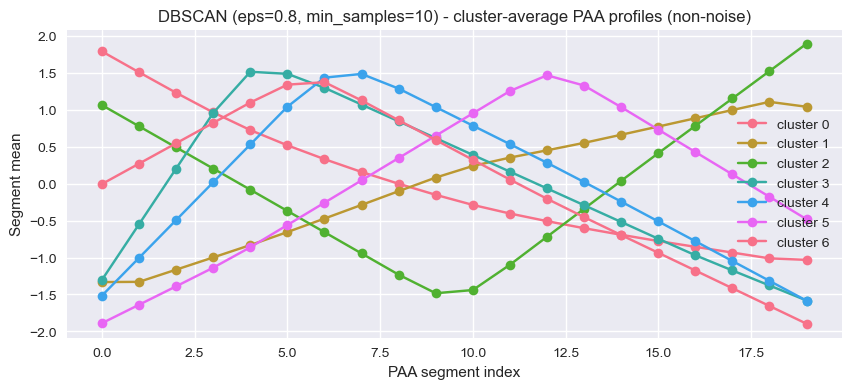

In [17]:
# DBSCAN clustering

# Try a couple of parameter combinations and inspect results
for eps in [0.5, 0.8, 1.0, 1.2]:
    for min_samples in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_paa_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        print(f"eps={eps}, min_samples={min_samples} -> clusters={n_clusters}, noise={n_noise}")

# Choose a reasonable combination after inspecting the above output
eps_db = 0.8
min_samples_db = 10

dbscan = DBSCAN(eps=eps_db, min_samples=min_samples_db)
dbscan_labels = dbscan.fit_predict(X_paa_scaled)

unique_db_labels = np.unique(dbscan_labels)
print("DBSCAN labels:", unique_db_labels)
print(pd.Series(dbscan_labels).value_counts().sort_index())

mask_non_noise = dbscan_labels != -1
if mask_non_noise.sum() > 0:
    plot_cluster_profiles(
        X_paa[mask_non_noise],
        dbscan_labels[mask_non_noise],
        f"DBSCAN (eps={eps_db}, min_samples={min_samples_db}) - cluster-average PAA profiles (non-noise)"
    )
else:
    print("All points considered noise for current DBSCAN parameters.")

### Summary and Comparison of Time Series Clustering Methods

- **Preprocessing and representation**  
  - Built univariate time series for each patient using a single laboratory signal (e.g. Glucose), as in Task 3.  
  - Applied **offset translation removal** and **amplitude scaling** (z-normalization), consistent with the time-series preprocessing slides.  
  - Used **Piecewise Aggregate Approximation (PAA)** to obtain a fixed-length feature vector per patient, enabling Euclidean-distance-based clustering.

- **KMeans (Euclidean on PAA)**  
  - Fast, centroid-based method; number of clusters selected via an **elbow plot**.  
  - Produces compact, roughly spherical clusters in the PAA feature space.

- **Hierarchical clustering (Ward)**  
  - Uses the same feature space but yields a **dendrogram** and nested structure of clusters.  
  - Allows exploration of different granularities by cutting the tree at different levels.

- **DBSCAN**  
  - Density-based approach on PAA features, identifying **dense groups** of similar trajectories and marking outliers as **noise**.  
  - Useful for spotting atypical time series patterns that do not belong to any dense cluster.

All methods operate purely on **time series / PAA features**, fulfilling the project requirement to cluster the preprocessed time series rather than tabular patient attributes.